# Ex_Classification_trees

- [Import IKEA Furniture Data-Set](#Import-Ikea-Furniture-Data-Set)
    - [Data Preprocessing](#Data-Preprocessing)
- [Create Classification Tree](#Create-Classification-Tree)
    - [Visualization of the Classification Tree](#Visualization-of-the-Classification-Tree)
- [Compute Training Error Rate](#Compute-Training-Error-Rate)
- [Split Data](#Split-Data)
- [Compute Test Error Rate](#Compute-Test-Error-Rate)
- [Notes about Pruning](#Notes-about-Pruning)

We are exploring the method of Classification Trees in order to classify the IKEA Furniture Data-Set. One advantage of Trees is, that they can easily handle qualitative variables without the use of dummy variables. Therefor, this method seems to be particularly fitting for the classification problem at hand.

In [180]:
# Import packages
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import graphviz

from matplotlib import pyplot as plt
from IPython.display import Image, display
%matplotlib inline
plt.style.use('ggplot')

## Import IKEA Furniture Data-Set

In [182]:
with open('Data/IKEA_df.p', 'rb') as df:
    IKEA_df = pickle.load(df)

IKEA_df.head(4)

item_id                   name       category   price     old_price  \
0  90420332               FREKVENS  Bar furniture   265.0  No old price   
1    368814              NORDVIKEN  Bar furniture   995.0  No old price   
2   9333523  NORDVIKEN / NORDVIKEN  Bar furniture  2095.0  No old price   
3  80155205                   STIG  Bar furniture    69.0  No old price   

   sellable_online                                               link  \
0             True  https://www.ikea.com/sa/en/p/frekvens-bar-tabl...   
1            False  https://www.ikea.com/sa/en/p/nordviken-bar-tab...   
2            False  https://www.ikea.com/sa/en/p/nordviken-nordvik...   
3             True  https://www.ikea.com/sa/en/p/stig-bar-stool-wi...   

   other_colors                   short_description              designer  \
0         False               Bar table, in/outdoor  Nicholai Wiig Hansen   
1         False                           Bar table     Francis Cayouette   
2         False          Bar table and 4 bar stools     Francis Cayouette   
3          True             Bar stool with backrest         Henrik Preutz   

   ...  designer_len                 size              unit  \
0  ...            20             51x51 cm                cm   
1  ...            17            140x80 cm                cm   
2  ...            17                  NaN               NaN   
3  ...            13                74 cm                cm   

         size_nounit depth_median depth_mean height_mean  height_median  \
0             51x51          47.0  45.725926   97.571429          102.0   
1            140x80          47.0  45.725926   97.571429          102.0   
2                NaN         47.0  45.725926   97.571429          102.0   
3                74          47.0  45.725926   97.571429          102.0   

   width_median  width_mean  
0          48.0    52.07027  
1          48.0    52.07027  
2          48.0    52.07027  
3          48.0    52.07027  

[4 rows x 23 columns]

## Data Preprocessing

item_id                   name       category   price     old_price  \
0  90420332               FREKVENS  Bar furniture   265.0  No old price   
1    368814              NORDVIKEN  Bar furniture   995.0  No old price   
2   9333523  NORDVIKEN / NORDVIKEN  Bar furniture  2095.0  No old price   
3  80155205                   STIG  Bar furniture    69.0  No old price   

   sellable_online                                               link  \
0             True  https://www.ikea.com/sa/en/p/frekvens-bar-tabl...   
1            False  https://www.ikea.com/sa/en/p/nordviken-bar-tab...   
2            False  https://www.ikea.com/sa/en/p/nordviken-nordvik...   
3             True  https://www.ikea.com/sa/en/p/stig-bar-stool-wi...   

   other_colors                   short_description              designer  \
0         False               Bar table, in/outdoor  Nicholai Wiig Hansen   
1         False                           Bar table     Francis Cayouette   
2         False          Bar table and 4 bar stools     Francis Cayouette   
3          True             Bar stool with backrest         Henrik Preutz   

   ...        size_nounit  depth_median  depth_mean  height_mean  \
0  ...             51x51           47.0   45.725926    97.571429   
1  ...            140x80           47.0   45.725926    97.571429   
2  ...                NaN          47.0   45.725926    97.571429   
3  ...                74           47.0   45.725926    97.571429   

  height_median width_median width_mean  low_price  high_price  medium_price  
0         102.0         48.0   52.07027      False       False          True  
1         102.0         48.0   52.07027      False       False          True  
2         102.0         48.0   52.07027      False        True         False  
3         102.0         48.0   52.07027       True       False         False  

[4 rows x 26 columns]

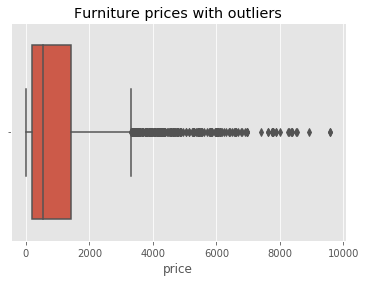

In [183]:
## in the following 3 price-segments in order to ensure a better predictability later on
# the 3 price-segments are low-, medium-, and high-price 
# use Boxplot to determine the limits of the 3 price-categories

sns.boxplot(IKEA_df['price']) #boxplot with outliers
plt.title('Furniture prices with outliers')

Q1 = IKEA_df['price'].quantile(0.25)   #first quantile
Q3 = IKEA_df['price'].quantile(0.75)   #third quantile
IQR = Q1 - Q3                          #intermediate quantile range


# this data is not really needed for now
max_price = max(IKEA_df.price) 
min_price = min(IKEA_df.price)  
medium_price = np.mean(IKEA_df.price)
median_price = np.median(IKEA_df.price)

# add the price-categories to the data-set 
IKEA_df['low_price'] = IKEA_df.price <= Q1
IKEA_df['high_price'] = IKEA_df.price >= Q3
IKEA_df['medium_price'] = (IKEA_df.price > Q1) == (IKEA_df.price < Q3)

IKEA_df.head(4)

In [184]:
# drop the unnecessary columns -- remember the number of dummies is always one less than the number of levels
#TODO: do we have dummies? How do I identify those?
#removed 'item_ID' because its individual, same goes for 'link'
#removed 'price' because instead high-medium-low-price-segment data is used 

learn = ['item_id','name','category','price','sellable_online','other_colors','designer','depth','height','width' ]
#learn_2 = ['item_id','name','category','low_price','medium_price','high_price','sellable_online','other_colors','designer','depth','height','width' ]

# choose learn for now
learn_df = IKEA_df [learn]

#IKEA_df = IKEA_df.drop(['item_id', 'link', 'price'],axis=1) 
#IKEA_df.head(3)

In [185]:
#check if there is still  NaN in dataset
learn_df[learn_df.isna().any(axis =1)]['item_id'].count()

0

### Factorize the Data

In [186]:
#this cell gives warning about setting copy. this warining can be ignored in this project
#encode nominal feature into numeric ones
learn_df['category_num'] = pd.factorize(learn_df['category'])[0] + 1
learn_df['name'] = pd.factorize(learn_df['name'])[0] + 1
#learn_df['sellable_online'] = pd.factorize(learn_df['sellable_online'])[0] + 1
#learn_df['other_colors'] = pd.factorize(learn_df['other_colors'])[0] + 1
learn_df['designer'] = pd.factorize(learn_df['designer'])[0] + 1

/Users/alissaganter/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/alissaganter/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/alissaganter/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is tr

In [187]:
label = IKEA_df['category'].unique()
label = label.tolist()
print('labels:', label)

labels: ['Bar furniture', 'Beds', 'Bookcases & shelving units', 'Cabinets & cupboards', 'Café furniture', 'Chairs', 'Chests of drawers & drawer units', "Children's furniture", 'Nursery furniture', 'Outdoor furniture', 'Room dividers', 'Sideboards, buffets & console tables', 'Sofas & armchairs', 'Tables & desks', 'Trolleys', 'TV & media furniture', 'Wardrobes']


In [188]:
# determine the number of features that can be used to predict the item-category
t = learn_df.drop(columns = ['category','category_num']).shape[1] 
print('There are '+str(t)+' features.')

There are 9 features.


After these small modifications, the data set is now suitable for the algorithm. 

## Create Classification Tree

In [245]:
# import tree, confusion_matrix, accuracy_score and train_test_split from sklearn library
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
# make a split using 67% of the data for training and the remainder for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [205]:
clf = tree.DecisionTreeClassifier(min_samples_split=20)

# get the predictors
# fit a decision tree to predict 'category' from the data. For that, remove 'category' from the predictors
predictors = learn_df.columns.tolist()
predictors.remove('category')
predictors.remove('category_num')

X = learn_df[predictors].values

# get the response
y = learn_df.category.values.reshape(-1,1)

# Train the model
tree_est = clf.fit(X_train, y_train)

# make predictions 
y_pred = tree_est.predict(X_test)

['item_id', 'name', 'price', 'sellable_online', 'other_colors', 'designer', 'depth', 'height', 'width']


#### Visualization of the Classifcation Tree

In [190]:
# use sklearn's export to generate the dot-data string file with all the nodes and their props.
dot_data = tree.export_graphviz(tree_est, out_file='seat_tree_1.dot',feature_names=predictors, 
                filled=True, rounded=True, special_characters=True) #class_names=['True', 'False']



with open('seat_tree_1.dot') as f:
    dot_graph = f.read()  

# create the source object
I = graphviz.Source(dot_graph, format='png', engine='dot')
# Use ipython Image to shrink the rendered image of the source obj to fit into jupyter nb.
Image(I.render())
# also show the view of the source object in browser so we can zoom in on nodes and see what we've got
I.view()

So we see that the initial splitting occurs with Depth and Height predictors. 

#### Investigate the importance of the individual features
This is done by comparing the average Gini Index of the different features. The Gini Index of the different features can be retrieved from sklearn:

In [192]:
feature_importances = tree_est.feature_importances_
pd.DataFrame(data=feature_importances, index=predictors, columns = ['Importance']).sort_values(by=['Importance'], 
                                                                                                ascending=False)

Importance
depth              0.393015
height             0.295655
name               0.216765
width              0.029038
price              0.028703
designer           0.024301
item_id            0.008942
other_colors       0.003580
sellable_online    0.000000

#### Compute Training Error Rate

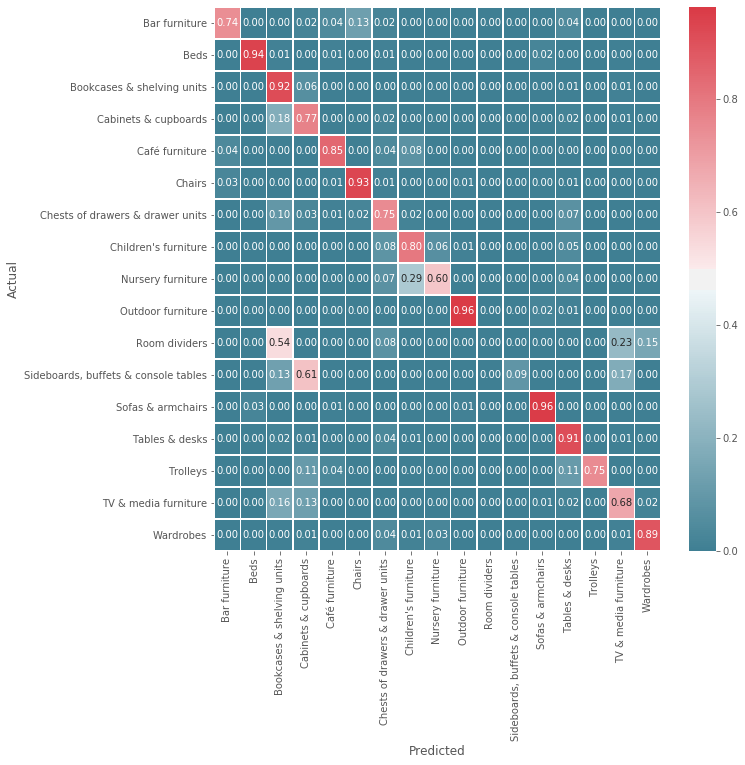

In [193]:
cmatrix_test = 
error_rate = (cmatrix_test[0,1]+cmatrix_test[1,0])/cmatrix_test.sum()
print("Test Error Rate:", error_rate)

# Lets also get the training error rate of the tree model
#y_labels = IKEA_df['category'].unique()
cm = confusion_matrix(y_true = y_test, y_pred=y_pred, labels=label) 
#print(cm)

# number of smaples actually belong to each category
cm_sum = cm.sum(axis = 1)

cm1 = np.zeros((len(label),len(label)))

# confusion matrix divided by  number of samples in test set belongs to each category 
for k in range(len(label)):
    cm1[k,:] = cm[k,:]/cm_sum[k]

# confusion_matrix normalized 
cm_df = pd.DataFrame(cm1,index = label, columns=label)

#plot confusion matrix 
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cm_df, annot=True, linewidths=.5,ax=ax,fmt='.2f',cmap = cmap)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.figure.savefig('Figures/Decision_Trees/DT_CM_1.png', bbox_inches = 'tight')

As assumed when analyzing the given dataset, sellable_online does not have any importance as almost all products are sellable-online. Furthmeore, the Gini Index tells us, that other_colors and item_id have a small significance as well. 
other_colors ...
item_id is almost always individual and only in very view cases, an item_id is listed twice. Thus, this predictor does not have a large importance. 
In a nex step all features with an importance smaller than 2% are excluded in order to improve the results. 

### First Improvements

In [206]:
# adjust the learning-dataframe by removing other_colors and sellable_online from it. 
# item_id and category are not removed since we need them later on
learn1 = ['item_id','name','price','designer','depth','height','width','category','category_num' ]
learn_df1 = learn_df[learn1]

In [208]:
clf = tree.DecisionTreeClassifier(min_samples_split=20)

# get the predictors
# fit a decision tree to predict 'category' from the data. 
# This time, remove 'item_id', 'other_colors' and 'sellable_online' from the predictors 
#in addition to 'category' and 'category_num' (which was already done previously)
predictors.remove('item_id')
predictors.remove('other_colors')
predictors.remove('sellable_online')

X = learn_df1[predictors].values

# get the response
y = learn_df1.category.values.reshape(-1,1)

# Build classification tree
tree_est = clf.fit(X, y)

In [209]:
# use sklearn's export to generate the dot-data string file with all the nodes and their props.
dot_data = tree.export_graphviz(tree_est, out_file='seat_tree_2.dot',feature_names=predictors, 
                filled=True, rounded=True, special_characters=True) #class_names=['True', 'False']



with open('seat_tree_2.dot') as f:
    dot_graph = f.read()  

# create the source object
I = graphviz.Source(dot_graph, format='png', engine='dot')
# Use ipython Image to shrink the rendered image of the source obj to fit into jupyter nb.
Image(I.render())
# also show the view of the source object in browser so we can zoom in on nodes and see what we've got
I.view()

'Source.gv.png'

#### Investigate the importance of the individual features

In [210]:
feature_importances = tree_est.feature_importances_
pd.DataFrame(data=feature_importances, index=predictors, columns = ['Importance']).sort_values(by=['Importance'], 
                                                                                                ascending=False)

Importance
depth       0.395136
height      0.302164
name        0.220087
width       0.030666
price       0.028458
designer    0.023489

#### Compute Training Error Rate

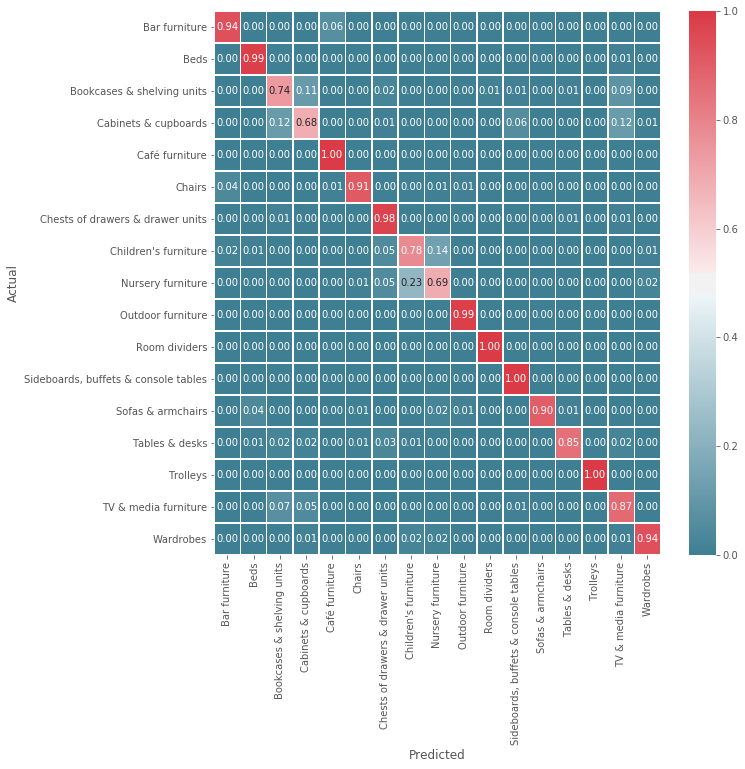

In [246]:
# Lets also get the training error rate of the tree model
#y_labels = IKEA_df['category'].unique()
cm = confusion_matrix(y_true = y, y_pred=tree_est.predict(X), labels=label)
#print(cmatrix)

# number of smaples actually belong to each category
cm_sum = cm.sum(axis = 1)

cm1 = np.zeros((len(label),len(label)))

# confusion matrix divided by  number of samples in test set belongs to each category 
for k in range(len(label)):
    cm1[k,:] = cm[k,:]/cm_sum[k]

# confusion_matrix normalized 
cm_df = pd.DataFrame(cm1,index = label, columns=label)

#plot confusion matrix 
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cm_df, annot=True, linewidths=.5,ax=ax,fmt='.2f',cmap = cmap)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.figure.savefig('Figures/Decision_Trees/DT_CM_2.png', bbox_inches = 'tight')

#### Replicate the samples for small sample size category  

Now we replicate the samples of category **Room dividers** and **Sideboards, buffets & console tables** in dataset to make this multi class classification task be relative balanced and see of it will significantly iprove the performance.

In [212]:
#recall the sample size of each category
size_df = learn_df1.groupby('category').size().reset_index(name='size')
size_df

category  size
0                          Bar furniture    47
1                                   Beds   208
2             Bookcases & shelving units   548
3                   Cabinets & cupboards   292
4                         Café furniture    26
5                                 Chairs   481
6       Chests of drawers & drawer units   125
7                   Children's furniture   124
8                      Nursery furniture    97
9                      Outdoor furniture   216
10                         Room dividers    13
11  Sideboards, buffets & console tables    23
12                     Sofas & armchairs   428
13                  TV & media furniture   190
14                        Tables & desks   612
15                              Trolleys    28
16                             Wardrobes   236

In [213]:
# careful here the order of the labels somehow changed compared to the list 'label' above. The order of TV & median furniture
# tables& dsks and trollyes somehow echanged as can be seen below . Thus, we cannot use the list label to display the correct order of 
# column names in this section.
label1 =size_df['category'].tolist()

In [224]:
if label!=label1:
    print('Label does not equal label1. In the following, therefore label1 will be used.')


Label does not equal label1. In the following, therefore label1 will be used.


In [225]:
label_size = size_df['size'].tolist()
label_size

[47, 208, 548, 292, 26, 481, 125, 124, 97, 216, 13, 23, 428, 190, 612, 28, 236]

In [228]:
learn_df2 = learn_df1.copy(deep=True)

In [229]:
# using label1 instead of label !!!!!
#print(learn_df2.shape[0])
for k in range(len(label1)):
    temp_df = learn_df1[learn_df1['category'].str.contains(label1[k])] 
    #print('original size' + str(temp_df.shape[0]))
    #print('label_size' +str(label_size[k]))
    tt = round(max(label_size)/label_size[k]) -1
    #print('to replicate' + str(tt))
    if tt > 0:
        temp_df1 = pd.concat([temp_df]*tt, ignore_index=True)
        #print('df_repl size' +str(temp_df1.shape[0]))
        learn_df2 = pd.concat([learn_df2, temp_df1] , ignore_index=True)
        #print(learn_df2.shape[0])

In [230]:
# old dataset imbalanced
size_df

category  size
0                          Bar furniture    47
1                                   Beds   208
2             Bookcases & shelving units   548
3                   Cabinets & cupboards   292
4                         Café furniture    26
5                                 Chairs   481
6       Chests of drawers & drawer units   125
7                   Children's furniture   124
8                      Nursery furniture    97
9                      Outdoor furniture   216
10                         Room dividers    13
11  Sideboards, buffets & console tables    23
12                     Sofas & armchairs   428
13                  TV & media furniture   190
14                        Tables & desks   612
15                              Trolleys    28
16                             Wardrobes   236

In [231]:
#new relative balanced data set with duplicated samples
size_df2 = learn_df2.groupby('category').size().reset_index(name='size')
size_df2

category  size
0                          Bar furniture   611
1                                   Beds   624
2             Bookcases & shelving units   548
3                   Cabinets & cupboards   584
4                         Café furniture   624
5                                 Chairs   481
6       Chests of drawers & drawer units   625
7                   Children's furniture   620
8                      Nursery furniture   582
9                      Outdoor furniture   648
10                         Room dividers   611
11  Sideboards, buffets & console tables   621
12                     Sofas & armchairs   428
13                  TV & media furniture   570
14                        Tables & desks   612
15                              Trolleys   616
16                             Wardrobes   708

Now the data set has been modified to be a relative balanced ones , although there are now too many duplicated samples for category, which had too few samples before.

### Final model of the decision Tree

In [238]:
clf = tree.DecisionTreeClassifier(min_samples_split=20)

X = learn_df2[predictors].values

# get the response
y = learn_df2.category.values.reshape(-1,1)

# Build classification tree
tree_est = clf.fit(X, y)

In [250]:
# use sklearn's export to generate the dot-data string file with all the nodes and their props.
dot_data = tree.export_graphviz(tree_est, out_file='seat_tree_3.dot',feature_names=predictors, 
                filled=True, rounded=True, special_characters=True) #class_names=['True', 'False']



with open('seat_tree_3.dot') as f:
    dot_graph = f.read()  

# create the source object
I = graphviz.Source(dot_graph, format='png', engine='dot')
# Use ipython Image to shrink the rendered image of the source obj to fit into jupyter nb.
Image(I.render())
# also show the view of the source object in browser so we can zoom in on nodes and see what we've got
I.view()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.894369 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.894369 to fit


'Source.gv.png'

#### Investigate the importance of the individual features as predictors

In [240]:
feature_importances = tree_est.feature_importances_
pd.DataFrame(data=feature_importances, index=predictors, columns = ['Importance']).sort_values(by=['Importance'], 
                                                                                                ascending=False)

Importance
name        0.355319
depth       0.280922
height      0.181042
price       0.070525
width       0.063087
designer    0.049105

#### Compute training error rate

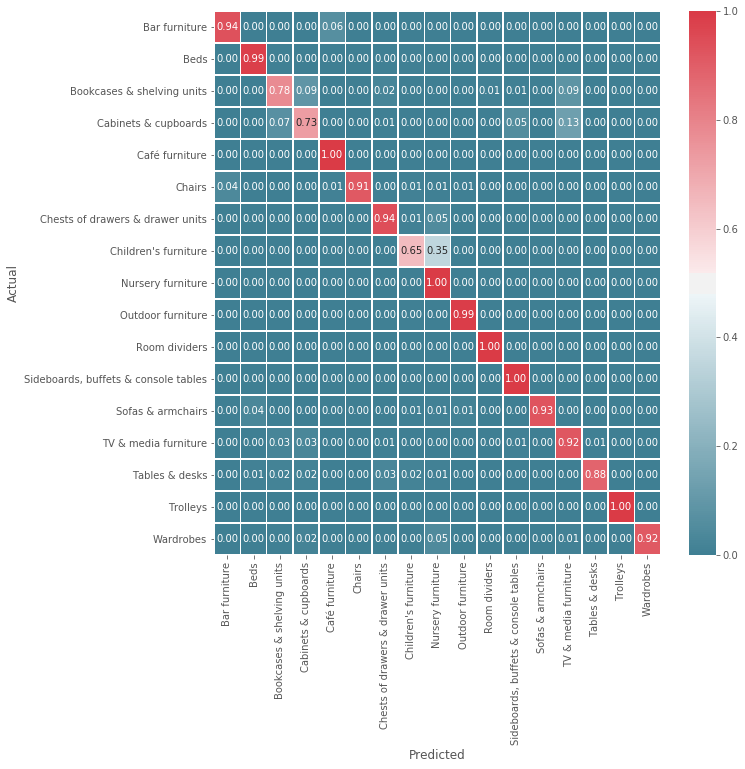

In [241]:
# Lets also get the training error rate of the tree model
#y_labels = IKEA_df['category'].unique()
cm = confusion_matrix(y_true = y, y_pred=tree_est.predict(X), labels=label1)
#print(cmatrix)

# number of smaples actually belong to each category
cm_sum = cm.sum(axis = 1)

cm1 = np.zeros((len(label1),len(label1)))

# confusion matrix divided by  number of samples in test set belongs to each category 
for k in range(len(label)):
    cm1[k,:] = cm[k,:]/cm_sum[k]

# confusion_matrix normalized 
cm_df = pd.DataFrame(cm1,index = label1, columns=label1)

#plot confusion matrix 
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cm_df, annot=True, linewidths=.5,ax=ax,fmt='.2f',cmap = cmap)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.figure.savefig('Figures/Decision_Trees/DT_CM_3.png', bbox_inches = 'tight')

## Split Data for the final decision tree

## Compute Test Error Rate

In [251]:
# Train the model
tree_est = clf.fit(X_train, y_train)
# make predictions 
y_pred = tree_est.predict(X_test)

cmatrix_test = confusion_matrix(y_true = y_test, y_pred=y_pred, labels=label1)
a = accuracy_score(y_test, y_pred)
print("Test Error Rate:", error_rate)

Test Error Rate: 0.000819672131147541


Is this value influenced by the train test split and by the splitting criterion? (Before we used 20 samples as value - we stopped splitting when 20 samples were left -)

Now we try out different parameter settings to see if we can get better predictions. After trail and error we keep the following parameter sets to show the impact of those parameters. Best minimum samples in leaf is 1 (we set 5 before), if increase the size the overall predictions accuracy goes down. Normally the acurracy increase with the size of forest until reaching certain threshold and the accuracy become stable. In total those parameters just influence the overall acuracy less than 0.01, and the best overall accuracy witih random forest is about 90.27% for minimum_samples_leaf =1, n_tree = 400. Here we won't check the single confusion matrix, since the dataset is now balanced w.r.t sample size of each category.

## Notes about Pruning

Pruning for a classification Tree involves selecting a set of subtrees as a function of a penalization factor $\alpha $ according to the equation $\sum_{m=1}^{|T|}\sum_{i: x_i \in R_m}(y_i-\hat{y})^2+\alpha|T|$ and then using CV to find the optimal subtree. Sklearn does not provide any methods in their tree class to accomplish pruning. To implement this, we would need to develop a way to prune the returned tree object from sklearn. Since, pruned trees are not as competitive, in terms of predictive accuracy, with other models we will move on. 